In [3]:
import numpy as np
from collections import defaultdict

class TSPSolverSOVA:
    def __init__(self, dist_matrix, bp_iterations=20, damping=0.7, verbose=True):
        self.dist_matrix = np.array(dist_matrix)
        self.num_nodes = self.dist_matrix.shape[0]
        self.N = self.num_nodes - 1
        self.depot = self.N
        self.bp_iterations = bp_iterations
        self.damping = damping
        self.verbose = verbose
        self.INF = 1e12
        self.FULL_MASK = (1 << self.N) - 1
        
        max_dist = np.max(self.dist_matrix)
        self.S = max_dist - self.dist_matrix
        np.fill_diagonal(self.S, -self.INF) 
        
        # Messages initialization
        self.tilde_rho = np.zeros((self.N, self.N))
        self.tilde_eta = np.zeros((self.N, self.N))
        self.tilde_phi = np.zeros((self.N, self.N))

    def log(self, msg):
        if self.verbose:
            print(msg)

    def _calc_lambda_sum_bias(self):
        """PDF Eq (1.2) Sum(lambda) 계산 (Beta 역할)"""
        N = self.N
        sum_rho_t = np.sum(self.tilde_rho, axis=1, keepdims=True)
        lambda_sum_bias = -self.tilde_rho + ((N - 1) / N) * sum_rho_t
        return lambda_sum_bias

    def _run_trellis(self):
        N, S, depot = self.N, self.S, self.depot
        bias = self._calc_lambda_sum_bias()
        
        # --- [1] Forward (Alpha) ---
        alpha = [defaultdict(lambda: -self.INF) for _ in range(N + 1)]
        alpha[0][(0, depot)] = 0.0
        
        # 최적화: 루프 내 변수 접근 최소화
        for t in range(N):
            current_bias = bias[t]
            next_alpha = alpha[t+1]
            # items() 복사 오버헤드 방지
            for state, prev_score in alpha[t].items():
                if prev_score < -self.INF / 2: continue
                    
                mask, prev_node = state
                
                # 방문 가능한 노드만 순회 (비트 연산 최적화 가능하지만 가독성 유지)
                # N이 작으므로 range(N) 루프는 빠름
                for i in range(N):
                    if not (mask & (1 << i)):
                        new_mask = mask | (1 << i)
                        val = prev_score + S[prev_node, i] + current_bias[i]
                        
                        if val > next_alpha[(new_mask, i)]:
                            next_alpha[(new_mask, i)] = val

        # --- [2] Backward (Beta) ---
        # Beta는 로직 동일, 코드 생략 없이 최적화만 적용
        beta = [defaultdict(lambda: -self.INF) for _ in range(N + 2)]
        final_mask = self.FULL_MASK
        
        for i in range(N):
            beta[N][(final_mask, i)] = S[i, depot]
            
        for t in range(N - 1, -1, -1):
            curr_bias = bias[t]
            curr_beta = beta[t]
            
            for next_state, next_beta_val in beta[t+1].items():
                if next_beta_val < -self.INF / 2: continue
                next_mask, next_node = next_state
                
                # Xi 값 미리 계산
                xi_val = next_beta_val + curr_bias[next_node]
                
                prev_mask = next_mask & ~(1 << next_node)
                
                # 후보군 추출
                if prev_mask == 0:
                    cands = [depot]
                else:
                    cands = [j for j in range(N) if prev_mask & (1 << j)]
                    
                for prev in cands:
                    val = S[prev, next_node] + xi_val
                    state = (prev_mask, prev)
                    if val > curr_beta[state]:
                        curr_beta[state] = val

        # --- [3] Soft Output (Delta) 최적화 (핵심!) ---
        # 기존: O(N^2 * States) -> 최적화: O(States + N^2)
        tilde_delta = np.zeros((N, N))
        
        for t in range(N):
            # 1. 해당 시간 t의 도시별 최대 점수(City Max Scores)를 한 번의 루프로 수집
            city_max_scores = np.full(N, -self.INF)
            
            # alpha와 beta가 존재하는 상태만 빠르게 스캔
            for state, f_score in alpha[t+1].items():
                if f_score < -self.INF / 2: continue
                if state in beta[t+1]:
                    b_score = beta[t+1][state]
                    if b_score > -self.INF / 2:
                        total = f_score + b_score
                        city = state[1]
                        if total > city_max_scores[city]:
                            city_max_scores[city] = total
            
            # 2. '자기 자신 제외 최대값'을 구하기 위한 전처리
            # 전체 최대값과 두 번째 최대값을 찾음
            sorted_indices = np.argsort(city_max_scores)[::-1] # 내림차순 정렬 인덱스
            best_idx = sorted_indices[0]
            second_best_idx = sorted_indices[1]
            
            global_max = city_max_scores[best_idx]
            global_second = city_max_scores[second_best_idx]

            # 3. Delta 계산 (벡터화)
            # lam_i_for_i = -1/N * rho
            # lam_i_for_j = (N-1)/N * rho
            rho_t = self.tilde_rho[t]
            lam_i_for_i = -(1.0/N) * rho_t
            lam_i_for_j = ((N-1.0)/N) * rho_t
            
            # max_in: 내가 선택된 경우의 최대 점수
            max_in = city_max_scores - lam_i_for_i
            
            # max_out: 내가 선택되지 않았을 때(다른 도시 중) 최대 점수
            # 내가 1등이면 -> 2등 점수 사용, 내가 1등 아니면 -> 1등 점수 사용
            max_out_raw = np.full(N, global_max)
            max_out_raw[best_idx] = global_second # 1등 자리는 2등 점수로 교체
            
            max_out = max_out_raw - lam_i_for_j
            
            # 최종 차이 계산 (Inf 처리 포함)
            diff = np.where(max_in < -self.INF/2, -self.INF,
                            np.where(max_out < -self.INF/2, self.INF, max_in - max_out))
            
            tilde_delta[t] = diff
                
        return alpha, tilde_delta

    def _run_bp(self, tilde_delta):
        """
        Numpy Broadcasting을 이용한 BP 완전 최적화
        O(N^3) -> O(N^2)
        """
        N = self.N
        
        # 1. Omega 계산
        t_omega = self.tilde_phi + tilde_delta
        
        # 2. Eta 계산 (Row 방향 Max Excluding Self)
        # 각 열(Column)에서 특정 행(t)을 제외한 최대값 구하기
        # - 전체 최대값(max1)과 두번째 최대값(max2)을 구해서 처리
        col_max_idx = np.argmax(t_omega, axis=0) # 각 열의 최대값 위치(행 인덱스)
        col_max_val = np.max(t_omega, axis=0)    # 각 열의 최대값
        
        # 두 번째 최대값을 구하기 위해 최대값 위치를 -INF로 잠시 변경
        temp_omega = t_omega.copy()
        for c in range(N):
            temp_omega[col_max_idx[c], c] = -self.INF
        col_second_max = np.max(temp_omega, axis=0)
        
        # new_eta 구성
        # t가 최대값 위치가 아니면 -> 최대값 사용
        # t가 최대값 위치면 -> 두 번째 최대값 사용
        new_eta = np.zeros((N, N))
        for t in range(N):
            # t행이 해당 열(c)의 최대값 위치인지 체크
            is_max_pos = (col_max_idx == t)
            # True면 second_max, False면 max_val
            new_eta[t] = np.where(is_max_pos, col_second_max, col_max_val)
        new_eta = -new_eta # 부호 반전

        # 3. Gamma 계산
        t_gamma = new_eta + tilde_delta
        
        # 4. Phi 계산 (Col 방향 Max Excluding Self)
        # 이번엔 각 행(Row)에서 특정 열(i)을 제외한 최대값
        row_max_idx = np.argmax(t_gamma, axis=1)
        row_max_val = np.max(t_gamma, axis=1)
        
        temp_gamma = t_gamma.copy()
        for r in range(N):
            temp_gamma[r, row_max_idx[r]] = -self.INF
        row_second_max = np.max(temp_gamma, axis=1)
        
        new_phi = np.zeros((N, N))
        for i in range(N):
            is_max_pos = (row_max_idx == i)
            # 전치(Transpose) 주의: new_phi[t, i] 이므로 t 루프 대신 열벡터 연산
            # 여기서는 이중 루프 없이 브로드캐스팅을 위해 전치 사용이 헷갈릴 수 있으므로 
            # 단순하게 열 단위 할당
            new_phi[:, i] = np.where(row_max_idx == i, row_second_max, row_max_val)
            
        new_phi = -new_phi # 부호 반전
        
        # Update with Damping
        self.tilde_eta = self.damping * self.tilde_eta + (1 - self.damping) * new_eta
        self.tilde_phi = self.damping * self.tilde_phi + (1 - self.damping) * new_phi
        self.tilde_rho = self.tilde_eta + self.tilde_phi

    def _extract_path(self, alpha):
        path = []
        curr_mask = self.FULL_MASK
        best_score = -self.INF
        best_last = -1

        # 1) 마지막 도시 선택
        for i in range(self.N):
            state = (curr_mask, i)
            if state in alpha[self.N]:
                score = alpha[self.N][state] + self.S[i, self.depot]
                if score > best_score:
                    best_score = score
                    best_last = i

        if best_last == -1:
            return [], self.INF

        # 초기 상태
        path = [self.depot, best_last]
        curr_node = best_last
        curr_mask = self.FULL_MASK ^ (1 << best_last)

        # 2) 역추적
        for t in range(self.N - 1, 0, -1):

            cands = [j for j in range(self.N) if curr_mask & (1 << j)]  # depot 제거

            best_prev = -1
            best_val = -self.INF

            for prev in cands:
                state = (curr_mask, prev)
                if state in alpha[t]:
                    val = alpha[t][state] + self.S[prev, curr_node]   # bias 제거 (이미 α에 포함됨)

                    if val > best_val:
                        best_val = val
                        best_prev = prev

            if best_prev == -1:
                print(f"Traceback failed at t={t}")
                return [], self.INF

            path.append(best_prev)
            curr_node = best_prev
            curr_mask ^= (1 << best_prev)

        path.append(self.depot)
        path.reverse()

        # cost 계산
        cost = sum(self.dist_matrix[path[k], path[k+1]] for k in range(len(path)-1))
        return path, cost

    def solve(self):
        best_global_path = []
        best_global_cost = self.INF
        
        print(f"Solving TSP (N={self.N}) with Alpha Visualization")
        
        for it in range(self.bp_iterations):
            alpha, tilde_delta = self._run_trellis()
            path, cost = self._extract_path(alpha)
            
            if cost < best_global_cost:
                best_global_cost = cost
                best_global_path = path
                print(f"[Iter {it}] Cost: {cost:.2f} (New Best!) | Path: {path}")
            else:
                if self.verbose:
                     print(f"[Iter {it}] Cost: {cost:.2f} | Path: {path}")

            self._run_bp(tilde_delta)
            
        return best_global_path, best_global_cost

In [4]:
class TSP_NearestNeighbor:
    """
    단순하고 빠르지만 최적해는 보장하지 않는 탐욕(Greedy) 알고리즘
    비교군(Baseline)으로 사용합니다.
    """
    def __init__(self, dist_matrix):
        self.dist = dist_matrix
        if isinstance(dist_matrix, pd.DataFrame):
            self.n = len(dist_matrix)
        else:
            self.n = dist_matrix.shape[0]

    def run(self):
        if self.n <= 1: return [0, 0], 0
            
        unvisited = set(range(1, self.n))
        current = 0
        path = [0]
        total_cost = 0
        
        get_dist = lambda i, j: self.dist.iloc[i, j] if isinstance(self.dist, pd.DataFrame) else self.dist[i][j]

        while unvisited:
            next_node = min(unvisited, key=lambda x: get_dist(current, x))
            total_cost += get_dist(current, next_node)
            path.append(next_node)
            unvisited.remove(next_node)
            current = next_node
        
        total_cost += get_dist(current, 0)
        path.append(0)
        return path, total_cost

In [5]:
class TSP_Random:
    """
    경로를 무작위(Random)로 섞어서 선택하는 알고리즘
    성능 비교를 위한 Baseline(무작위 선택 시의 성능)으로 사용합니다.
    """
    def __init__(self, dist_matrix):
        self.dist = dist_matrix
        if isinstance(dist_matrix, pd.DataFrame):
            self.n = len(dist_matrix)
        else:
            self.n = dist_matrix.shape[0]

    def run(self):
        if self.n <= 1: return [0, 0], 0
        
        # 1. 0번(시작점)을 제외한 나머지 노드들의 리스트 생성
        nodes = list(range(1, self.n))
        
        # 2. 리스트를 무작위로 섞음 (Shuffle)
        random.shuffle(nodes)
        
        # 3. 전체 경로 구성: 0 -> [무작위 노드들] -> 0
        path = [0] + nodes + [0]
        
        # 4. 총 비용 계산
        total_cost = 0
        get_dist = lambda i, j: self.dist.iloc[i, j] if isinstance(self.dist, pd.DataFrame) else self.dist[i][j]

        for i in range(len(path) - 1):
            curr_node = path[i]
            next_node = path[i+1]
            total_cost += get_dist(curr_node, next_node)
            
        return path, total_cost

In [6]:
import pandas as pd
import random
import numpy as np
import requests
import folium
import json
import time
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import haversine_distances
from concurrent.futures import ThreadPoolExecutor, as_completed
#%pip install tqdm
from tqdm import tqdm  # 진행상황 표시용 (없으면 pip install tqdm)

# [주의] 사용자분의 기존 TSP 클래스(TSPHypercubeBCJR_SOVA, TSP_NearestNeighbor 등)가 
# 반드시 이 코드 위쪽에 선언되어 있거나 import 되어 있어야 합니다.

# =========================================================
# [설정] 카카오 API 키 입력
# =========================================================
KAKAO_API_KEY = "29cf96c3bebe9f8caec569384f45f2b4"  # 실제 키로 변경하세요

# =========================================================
# 유틸리티 함수들 (기존과 동일)
# =========================================================
def get_road_distance(start_x, start_y, end_x, end_y):
    # ... (기존 코드 유지) ...
    url = "https://apis-navi.kakaomobility.com/v1/directions"
    params = {
        "origin": f"{start_x},{start_y}", "destination": f"{end_x},{end_y}",
        "priority": "RECOMMEND", "summary": True
    }
    headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
    try:
        resp = requests.get(url, params=params, headers=headers)
        if resp.status_code == 200:
            routes = resp.json().get('routes')
            if routes: return routes[0]['summary']['distance']
    except Exception:
        pass
    return haversine_distance(start_y, start_x, end_y, end_x)

def get_kakao_route_path(start_x, start_y, end_x, end_y):
    # ... (기존 코드 유지) ...
    # (내용 생략 - 위와 동일)
    pass 

def haversine_distance(lat1, lon1, lat2, lon2):
    # ... (기존 코드 유지) ...
    R = 6371000
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1-a))

def build_road_dist_matrix(coords_df):
    # ... (기존 코드 유지) ...
    n = len(coords_df)
    matrix = np.zeros((n, n))
    indices = coords_df.index.tolist()
    # 병렬 처리 중 print가 섞일 수 있으므로 제거하거나 최소화
    for i in range(n):
        for j in range(n):
            if i != j:
                src, dst = coords_df.iloc[i], coords_df.iloc[j]
                matrix[i][j] = get_road_distance(src['경도'], src['위도'], dst['경도'], dst['위도'])
    return pd.DataFrame(matrix, index=indices, columns=indices)

# =========================================================
# [핵심] 병렬 처리를 위한 작업 함수 정의
# =========================================================
def process_cluster(cluster_id, labels, centers, df):
    """
    하나의 클러스터에 대해 거리 행렬을 만들고 TSP를 수행하는 함수
    """
    try:
        # 해당 클러스터에 속한 인덱스 추출
        m_idxs = np.where(labels == cluster_id)[0].tolist()
        c_idx = centers[cluster_id]
        
        # 중심점을 리스트의 맨 앞으로 이동 (Head)
        if c_idx in m_idxs: 
            m_idxs.remove(c_idx)
        m_idxs.insert(0, c_idx)
        
        # 서브 데이터프레임 생성
        sub_df = df.iloc[m_idxs]
        
        # [API 호출 구간] 거리 행렬 생성
        road_mat = build_road_dist_matrix(sub_df)
        
        # [TSP 알고리즘 수행]
        # 주의: 사용자 정의 클래스(TSPHypercubeBCJR_SOVA, TSP_NearestNeighbor)가 정의되어 있어야 함
        
        # [A] SOVA
        # (TSP 클래스 정의가 코드에 포함되어 있다고 가정)
        p_opt, c_opt = TSPSolverSOVA(road_mat).solve()
        gp_opt = [m_idxs[x] for x in p_opt] # 전체 인덱스로 변환
        
        # [B] NN
        p_nn, c_nn = TSP_NearestNeighbor(road_mat).run()
        gp_nn = [m_idxs[x] for x in p_nn]   # 전체 인덱스로 변환

        # [C] Random
        p_random, c_random = TSP_Random(road_mat).run()
        gp_random = [m_idxs[x] for x in p_random]  # 전체 인덱스로 변환
        
        return {
            'cluster_id': cluster_id,
            'head': c_idx,
            'opt': (gp_opt, c_opt),
            'nn': (gp_nn, c_nn),
            'random': (gp_random, c_random),
            'status': 'success'
        }
    except Exception as e:
        print(f"Error in Cluster {cluster_id}: {e}")
        return {'cluster_id': cluster_id, 'status': 'fail'}

# =========================================================
# 3. 메인 로직 실행
# =========================================================
if __name__ == "__main__":

    cluster_dist_sova = []
    cluster_dist_nn = []
    cluster_dist_random = []
    # [1] 데이터 로드
    print("[1] 데이터 로드...")
    try: df = pd.read_csv("서울특별시 성북구_의류수거함 현황_20240307.csv", encoding='cp949')
    except: df = pd.read_csv("서울특별시 성북구_의류수거함 현황_20240307.csv", encoding='utf-8')

    # [2] 클러스터링
    print("[2] Affinity Propagation 클러스터링...")
    coords_rad = np.radians(df[['위도', '경도']].values)
    sim = -(haversine_distances(coords_rad) * 6371000)
    pref = np.percentile(sim, 50) 
    
    af = AffinityPropagation(affinity='precomputed', preference=pref, damping=0.9, random_state=42).fit(sim)
    labels, centers = af.labels_, af.cluster_centers_indices_
    n_clusters = len(centers)
    print(f"  -> {n_clusters}개 클러스터 생성")

    # [3] 경로 계산 (병렬 처리 적용)
    print(f"[3] 경로 계산 시작 (병렬 처리: {n_clusters}개 클러스터)...")
    
    cluster_results = {}
    total_dist_sova = 0
    total_dist_nn = 0
    total_dist_random = 0

    # max_workers: 동시에 실행할 스레드 수 (API 제한 고려하여 4~8 정도 추천)
    # 카카오 API 무료 사용량 제한이 있으니 너무 높게 설정하면 에러 날 수 있음
    MAX_WORKERS = 8 

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # 각 클러스터 작업을 스레드풀에 등록
        futures = [
            executor.submit(process_cluster, i, labels, centers, df) 
            for i in range(n_clusters)
        ]
        
        # 작업 완료되는 대로 결과 수집 (tqdm으로 진행바 표시)
        for future in tqdm(as_completed(futures), total=n_clusters, desc="Calculating Routes"):
            res = future.result()
            if res['status'] == 'success':
                cid = res['cluster_id']
                cluster_results[cid] = {
                    'head': res['head'], 
                    'opt': res['opt'], 
                    'nn': res['nn'],
                    'random': res['random']
                }
                # 총 거리 합산
                cluster_dist_sova.append(res['opt'][1])
                cluster_dist_nn.append(res['nn'][1])
                cluster_dist_random.append(res['random'][1])
                total_dist_sova += res['opt'][1]
                total_dist_nn += res['nn'][1]
                total_dist_random += res['random'][1]

    # [4] Head TSP (이 부분은 데이터가 작으므로 그냥 단일 실행)
    print("[4] Head 경로 계산...")
    head_mat = build_road_dist_matrix(df.iloc[centers])
    
    # (주의: Head TSP용 클래스 이름이 TSPSolverSOVA 인지 TSPHypercubeBCJR_SOVA 인지 확인 필요)
    hp_opt, hc_opt = TSPSolverSOVA(head_mat).solve() # 혹은 .solve()
    hgp_opt = [centers[x] for x in hp_opt]
    total_dist_sova += hc_opt 
    
    hp_nn, hc_nn = TSP_NearestNeighbor(head_mat).run()
    hgp_nn = [centers[x] for x in hp_nn]
    total_dist_nn += hc_nn 

    hp_random, hc_random = TSP_Random(head_mat).run()
    hgp_random = [centers[x] for x in hp_random]
    total_dist_random += hc_random

    # ★ 거리 출력
    print("\n" + "="*40)
    print(f" [최종 결과 비교]")
    print(f" 1. SOVA (점선) 총 이동 거리: {total_dist_sova:,.0f} m")
    print(f" 2. NN   (실선) 총 이동 거리: {total_dist_nn:,.0f} m")
    print(f" 3. Random   (실선) 총 이동 거리: {total_dist_random:,.0f} m")
    print("="*40 + "\n")
    # [5] 시각화 (도로 형상 적용)
    print("[5] 지도 생성 (도로 형상 적용)...")
    folium_colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'darkblue', 'cadetblue', 'black', 'pink']
    folium_hex = {'red':'#d63e2a', 'blue':'#38aadd', 'green':'#72b026', 'purple':'#d252b9', 'orange':'#f69730', 
                  'darkred':'#a23336', 'darkblue':'#0067a3', 'cadetblue':'#436978', 'black':'#303030', 'pink':'#ff91ea'}
    
    m = folium.Map(location=[df['위도'].mean(), df['경도'].mean()], zoom_start=14)
    
    # (1) 클러스터 내부 (PolyLine 유지 - API 호출 절약)
    for i, res in cluster_results.items():
        c_name = folium_colors[i % len(folium_colors)]
        c_hex = folium_hex.get(c_name, '#333333')
        
        # NN (실선)
        nn_coords = [[df.iloc[x]['위도'], df.iloc[x]['경도']] for x in res['nn'][0]]
        folium.PolyLine(nn_coords, color=c_hex, weight=8, opacity=0.4, tooltip=f"C{i} NN").add_to(m)
        
        # SOVA (점선)
        opt_coords = [[df.iloc[x]['위도'], df.iloc[x]['경도']] for x in res['opt'][0]]
        folium.PolyLine(opt_coords, color=c_hex, weight=3, opacity=1.0, dash_array='5,5', tooltip=f"C{i} SOVA").add_to(m)

        # Random (점선)
        random_coords = [[df.iloc[x]['위도'], df.iloc[x]['경도']] for x in res['random'][0]]
        folium.PolyLine(random_coords, color=c_hex, weight=3, opacity=1.0, dash_array='5,5', tooltip=f"C{i} Random").add_to(m)

        # 마커
        for idx in res['opt'][0]:
            lat, lon = df.iloc[idx]['위도'], df.iloc[idx]['경도']
            if idx == res['head']:
                folium.Marker([lat,lon], popup=f"Head C{i}", icon=folium.Icon(color=c_name, icon='trash', prefix='fa')).add_to(m)
            else:
                folium.CircleMarker([lat,lon], radius=5, color=c_hex, fill=True, fill_color='white').add_to(m)

    # (2) Head 경로 그리기 (★도로 형상 적용★)
    print("   -> Head 경로 도로 형상 다운로드 중...")
    
    # NN Head -> 실선 (빨강/검정 등 구분을 위해 'Gray' 사용하거나 Black 유지)
    full_path_nn = []
    for k in range(len(hgp_nn)-1):
        s_idx, e_idx = hgp_nn[k], hgp_nn[k+1]
        src, dst = df.iloc[s_idx], df.iloc[e_idx]
        seg_path = get_kakao_route_path(src['경도'], src['위도'], dst['경도'], dst['위도'])
        if not seg_path: seg_path = [[src['위도'], src['경도']], [dst['위도'], dst['경도']]]
        full_path_nn.extend(seg_path)
        
    folium.PolyLine(full_path_nn, color='black', weight=8, opacity=0.4, tooltip="Head NN (Road)").add_to(m)
    
    # SOVA Head -> 점선
    full_path_opt = []
    for k in range(len(hgp_opt)-1):
        s_idx, e_idx = hgp_opt[k], hgp_opt[k+1]
        src, dst = df.iloc[s_idx], df.iloc[e_idx]
        seg_path = get_kakao_route_path(src['경도'], src['위도'], dst['경도'], dst['위도'])
        if not seg_path: seg_path = [[src['위도'], src['경도']], [dst['위도'], dst['경도']]]
        full_path_opt.extend(seg_path)

    folium.PolyLine(full_path_opt, color='black', weight=3, opacity=1.0, dash_array='5,5', tooltip="Head SOVA (Road)").add_to(m)

    # Random Head -> 실선 (빨강/검정 등 구분을 위해 'Gray' 사용하거나 Black 유지)
    full_path_random = []
    for k in range(len(hgp_random)-1):
        s_idx, e_idx = hgp_random[k], hgp_random[k+1]
        src, dst = df.iloc[s_idx], df.iloc[e_idx]
        seg_path = get_kakao_route_path(src['경도'], src['위도'], dst['경도'], dst['위도'])
        if not seg_path: seg_path = [[src['위도'], src['경도']], [dst['위도'], dst['경도']]]
        full_path_random.extend(seg_path)

    folium.PolyLine(full_path_random, color='black', weight=8, opacity=0.4, tooltip="Head Random (Road)").add_to(m)

    m.save("성북구_의류수거함_최종_도로형상적용.html")
    print("지도 생성 완료!")

[1] 데이터 로드...
[2] Affinity Propagation 클러스터링...
  -> 19개 클러스터 생성
[3] 경로 계산 시작 (병렬 처리: 19개 클러스터)...


Calculating Routes:   5%|▌         | 1/19 [00:06<01:53,  6.32s/it]

Solving TSP (N=8) with Alpha Visualization
[Iter 0] Cost: 1470.03 (New Best!) | Path: [8, 3, 4, 5, 0, 6, 7, 1, 2, 8]
[Iter 1] Cost: 1611.02 | Path: [8, 2, 1, 7, 6, 0, 5, 4, 3, 8]
[Iter 2] Cost: 1676.20 | Path: [8, 6, 7, 2, 1, 0, 4, 3, 5, 8]
[Iter 3] Cost: 1676.20 | Path: [8, 6, 7, 2, 1, 0, 4, 3, 5, 8]
[Iter 4] Cost: 1676.20 | Path: [8, 6, 7, 2, 1, 0, 4, 3, 5, 8]
[Iter 5] Cost: 1645.63 | Path: [8, 5, 3, 4, 0, 7, 1, 2, 6, 8]
[Iter 6] Cost: 1615.85 | Path: [8, 2, 1, 7, 6, 0, 4, 3, 5, 8]
[Iter 7] Cost: 1645.63 | Path: [8, 5, 3, 4, 0, 7, 1, 2, 6, 8]
[Iter 8] Cost: 1611.02 | Path: [8, 2, 1, 7, 6, 0, 5, 4, 3, 8]
[Iter 9] Cost: 1645.63 | Path: [8, 5, 3, 4, 0, 7, 1, 2, 6, 8]
[Iter 10] Cost: 1698.15 | Path: [8, 2, 1, 7, 6, 5, 4, 3, 0, 8]
[Iter 11] Cost: 1645.63 | Path: [8, 5, 3, 4, 0, 7, 1, 2, 6, 8]
[Iter 12] Cost: 1698.15 | Path: [8, 2, 1, 7, 6, 5, 4, 3, 0, 8]
[Iter 13] Cost: 1722.30 | Path: [8, 7, 2, 1, 6, 5, 4, 3, 0, 8]
[Iter 14] Cost: 1722.30 | Path: [8, 7, 2, 1, 6, 5, 4, 3, 0, 8]
[Iter 15] 

Calculating Routes:  16%|█▌        | 3/19 [00:09<00:47,  2.98s/it]

[Iter 15] Cost: 1708.72 | Path: [10, 8, 4, 7, 3, 5, 6, 0, 9, 2, 1, 10]
[Iter 16] Cost: 1743.25 | Path: [10, 2, 1, 8, 4, 7, 3, 5, 6, 0, 9, 10]
[Iter 17] Cost: 1708.72 | Path: [10, 8, 4, 7, 3, 5, 6, 0, 9, 2, 1, 10]
[Iter 18] Cost: 1863.98 | Path: [10, 0, 9, 4, 7, 3, 5, 6, 8, 1, 2, 10]
[Iter 19] Cost: 1763.38 | Path: [10, 9, 2, 1, 8, 4, 7, 3, 5, 6, 0, 10]


Calculating Routes:  21%|██        | 4/19 [00:12<00:44,  2.98s/it]

Solving TSP (N=6) with Alpha Visualization
[Iter 0] Cost: 2162.26 (New Best!) | Path: [6, 5, 0, 4, 2, 3, 1, 6]
[Iter 1] Cost: 3285.69 | Path: [6, 1, 5, 2, 3, 0, 4, 6]
[Iter 2] Cost: 3295.96 | Path: [6, 2, 3, 1, 5, 0, 4, 6]
[Iter 3] Cost: 3295.96 | Path: [6, 2, 3, 1, 5, 0, 4, 6]
[Iter 4] Cost: 3295.96 | Path: [6, 2, 3, 1, 5, 0, 4, 6]
[Iter 5] Cost: 3295.96 | Path: [6, 2, 3, 1, 5, 0, 4, 6]
[Iter 6] Cost: 3295.96 | Path: [6, 2, 3, 1, 5, 0, 4, 6]
[Iter 7] Cost: 3444.89 | Path: [6, 0, 3, 1, 5, 2, 4, 6]
[Iter 8] Cost: 3354.24 | Path: [6, 0, 5, 1, 2, 3, 4, 6]
[Iter 9] Cost: 3354.24 | Path: [6, 0, 5, 1, 2, 3, 4, 6]
[Iter 10] Cost: 3354.24 | Path: [6, 0, 5, 1, 2, 3, 4, 6]
[Iter 11] Cost: 3354.24 | Path: [6, 0, 5, 1, 2, 3, 4, 6]
[Iter 12] Cost: 3354.24 | Path: [6, 0, 5, 1, 2, 3, 4, 6]
[Iter 13] Cost: 3354.24 | Path: [6, 0, 5, 1, 2, 3, 4, 6]
[Iter 14] Cost: 3354.24 | Path: [6, 0, 5, 1, 2, 3, 4, 6]
[Iter 15] Cost: 3354.24 | Path: [6, 0, 5, 1, 2, 3, 4, 6]
[Iter 16] Cost: 3354.24 | Path: [6, 0, 5, 1

Calculating Routes:  26%|██▋       | 5/19 [00:36<02:18,  9.89s/it]

[Iter 19] Cost: 2774.13 | Path: [12, 1, 9, 8, 4, 3, 0, 7, 2, 10, 6, 5, 11, 12]
[Iter 9] Cost: 3675.37 | Path: [14, 8, 9, 0, 7, 12, 13, 1, 11, 10, 6, 2, 3, 4, 5, 14]
[Iter 10] Cost: 2865.13 | Path: [14, 11, 10, 8, 9, 5, 7, 0, 3, 2, 1, 12, 13, 4, 6, 14]
[Iter 10] Cost: 3811.14 | Path: [14, 7, 12, 13, 1, 11, 10, 0, 9, 6, 4, 3, 2, 8, 5, 14]
[Iter 11] Cost: 2837.11 | Path: [14, 10, 11, 8, 9, 5, 6, 0, 3, 4, 2, 1, 12, 13, 7, 14]
[Iter 0] Cost: 4085.28 (New Best!) | Path: [15, 14, 13, 12, 0, 10, 11, 9, 7, 8, 5, 1, 6, 2, 3, 4, 15]
[Iter 11] Cost: 3621.90 | Path: [14, 8, 5, 4, 3, 2, 6, 0, 7, 12, 13, 1, 11, 10, 9, 14]
[Iter 12] Cost: 2886.05 | Path: [14, 10, 11, 8, 9, 5, 2, 1, 12, 13, 3, 4, 6, 0, 7, 14]
[Iter 12] Cost: 3676.12 | Path: [14, 8, 7, 12, 13, 1, 11, 10, 0, 9, 5, 4, 3, 2, 6, 14]
[Iter 13] Cost: 2837.11 | Path: [14, 10, 11, 8, 9, 5, 6, 0, 3, 4, 2, 1, 12, 13, 7, 14]
[Iter 13] Cost: 3506.34 | Path: [14, 8, 9, 5, 4, 3, 2, 6, 0, 7, 12, 13, 1, 10, 11, 14]
[Iter 1] Cost: 4338.07 | Path: [15, 1

Calculating Routes:  32%|███▏      | 6/19 [01:01<03:10, 14.67s/it]

[Iter 19] Cost: 2896.93 | Path: [14, 11, 10, 8, 9, 5, 4, 2, 1, 12, 13, 3, 0, 7, 6, 14]


Calculating Routes:  37%|███▋      | 7/19 [01:01<02:02, 10.18s/it]

[Iter 19] Cost: 3733.56 | Path: [14, 8, 7, 12, 13, 1, 11, 10, 0, 9, 5, 3, 4, 2, 6, 14]
[Iter 4] Cost: 4550.83 | Path: [15, 12, 14, 13, 0, 7, 8, 9, 10, 11, 2, 5, 1, 6, 3, 4, 15]
[Iter 5] Cost: 4760.30 | Path: [15, 12, 14, 13, 3, 4, 5, 1, 6, 2, 0, 7, 8, 9, 10, 11, 15]
[Iter 6] Cost: 4495.18 | Path: [15, 13, 2, 5, 1, 6, 3, 4, 7, 8, 9, 10, 11, 0, 12, 14, 15]
[Iter 7] Cost: 4644.70 | Path: [15, 12, 0, 7, 8, 9, 10, 11, 3, 4, 5, 1, 6, 2, 14, 13, 15]
[Iter 8] Cost: 4338.07 | Path: [15, 13, 3, 4, 5, 1, 6, 2, 0, 7, 8, 9, 10, 11, 12, 14, 15]
[Iter 9] Cost: 4519.88 | Path: [15, 4, 3, 1, 6, 2, 5, 0, 7, 8, 9, 10, 11, 12, 14, 13, 15]


Calculating Routes:  42%|████▏     | 8/19 [01:15<02:03, 11.18s/it]

Solving TSP (N=6) with Alpha Visualization
[Iter 0] Cost: 4339.00 (New Best!) | Path: [6, 0, 2, 1, 3, 4, 5, 6]
[Iter 1] Cost: 4577.00 | Path: [6, 5, 0, 2, 1, 3, 4, 6]
[Iter 10] Cost: 4644.70 | Path: [15, 12, 0, 7, 8, 9, 10, 11, 3, 4, 5, 1, 6, 2, 14, 13, 15]
[Iter 2] Cost: 5092.00 | Path: [6, 4, 5, 0, 2, 1, 3, 6]
[Iter 3] Cost: 4339.00 | Path: [6, 0, 2, 1, 3, 4, 5, 6]
[Iter 4] Cost: 5591.00 | Path: [6, 5, 4, 3, 0, 2, 1, 6]
[Iter 5] Cost: 6054.00 | Path: [6, 2, 1, 3, 4, 5, 0, 6]
[Iter 6] Cost: 6097.00 | Path: [6, 1, 3, 4, 5, 0, 2, 6]
[Iter 7] Cost: 4339.00 | Path: [6, 0, 2, 1, 3, 4, 5, 6]
[Iter 8] Cost: 4577.00 | Path: [6, 5, 0, 2, 1, 3, 4, 6]
[Iter 9] Cost: 4339.00 | Path: [6, 0, 2, 1, 3, 4, 5, 6]
[Iter 10] Cost: 5092.00 | Path: [6, 4, 5, 0, 2, 1, 3, 6]
[Iter 11] Cost: 4339.00 | Path: [6, 0, 2, 1, 3, 4, 5, 6]
[Iter 12] Cost: 6097.00 | Path: [6, 1, 3, 4, 5, 0, 2, 6]
[Iter 13] Cost: 6097.00 | Path: [6, 1, 3, 4, 5, 0, 2, 6]
[Iter 14] Cost: 6097.00 | Path: [6, 1, 3, 4, 5, 0, 2, 6]
[Iter 15]

Calculating Routes:  47%|████▋     | 9/19 [02:03<03:45, 22.59s/it]

Solving TSP (N=8) with Alpha Visualization
[Iter 0] Cost: 4455.00 (New Best!) | Path: [8, 7, 6, 1, 2, 3, 0, 4, 5, 8]
[Iter 1] Cost: 4873.00 | Path: [8, 7, 6, 2, 3, 0, 4, 5, 1, 8]
[Iter 2] Cost: 5037.00 | Path: [8, 1, 2, 3, 0, 4, 5, 7, 6, 8]
[Iter 3] Cost: 5455.00 | Path: [8, 2, 3, 0, 4, 5, 1, 7, 6, 8]
[Iter 4] Cost: 5151.00 | Path: [8, 7, 6, 0, 4, 2, 3, 5, 1, 8]
[Iter 5] Cost: 4455.00 | Path: [8, 7, 6, 1, 2, 3, 0, 4, 5, 8]
[Iter 6] Cost: 4873.00 | Path: [8, 7, 6, 2, 3, 0, 4, 5, 1, 8]
[Iter 7] Cost: 4455.00 | Path: [8, 7, 6, 1, 2, 3, 0, 4, 5, 8]
[Iter 8] Cost: 5037.00 | Path: [8, 1, 2, 3, 0, 4, 5, 7, 6, 8]
[Iter 9] Cost: 5151.00 | Path: [8, 7, 6, 0, 4, 2, 3, 5, 1, 8]
[Iter 10] Cost: 5151.00 | Path: [8, 7, 6, 0, 4, 2, 3, 5, 1, 8]
[Iter 11] Cost: 4455.00 | Path: [8, 7, 6, 1, 2, 3, 0, 4, 5, 8]
[Iter 12] Cost: 4873.00 | Path: [8, 7, 6, 2, 3, 0, 4, 5, 1, 8]
[Iter 13] Cost: 4455.00 | Path: [8, 7, 6, 1, 2, 3, 0, 4, 5, 8]
[Iter 14] Cost: 5037.00 | Path: [8, 1, 2, 3, 0, 4, 5, 7, 6, 8]
[Iter 15] 

Calculating Routes:  53%|█████▎    | 10/19 [02:07<02:30, 16.77s/it]

[Iter 19] Cost: 4774.74 | Path: [15, 14, 12, 0, 7, 8, 9, 10, 11, 3, 4, 5, 1, 6, 2, 13, 15]
[Iter 1] Cost: 6010.57 | Path: [16, 10, 9, 0, 7, 4, 5, 15, 11, 13, 12, 14, 1, 2, 3, 6, 8, 16]
Solving TSP (N=11) with Alpha Visualization
[Iter 0] Cost: 4734.00 (New Best!) | Path: [11, 10, 0, 9, 8, 1, 2, 3, 7, 6, 5, 4, 11]
[Iter 1] Cost: 4857.00 | Path: [11, 1, 2, 3, 7, 6, 5, 4, 9, 8, 0, 10, 11]
[Iter 2] Cost: 4954.00 | Path: [11, 9, 8, 1, 2, 3, 7, 6, 5, 4, 10, 0, 11]
[Iter 3] Cost: 4880.00 | Path: [11, 0, 9, 8, 1, 2, 3, 4, 7, 6, 5, 10, 11]
[Iter 4] Cost: 4989.00 | Path: [11, 1, 2, 3, 4, 7, 6, 5, 10, 0, 8, 9, 11]
[Iter 5] Cost: 4920.00 | Path: [11, 4, 7, 6, 5, 3, 2, 1, 8, 9, 10, 0, 11]
[Iter 6] Cost: 4931.00 | Path: [11, 1, 2, 3, 4, 7, 6, 5, 9, 8, 10, 0, 11]
[Iter 7] Cost: 4954.00 | Path: [11, 9, 8, 1, 2, 3, 4, 6, 7, 5, 10, 0, 11]
[Iter 8] Cost: 4954.00 | Path: [11, 9, 8, 1, 2, 3, 4, 6, 7, 5, 10, 0, 11]
[Iter 9] Cost: 4852.00 | Path: [11, 10, 0, 9, 8, 1, 3, 2, 7, 6, 5, 4, 11]
[Iter 10] Cost: 493

Calculating Routes:  58%|█████▊    | 11/19 [02:27<02:22, 17.79s/it]

[Iter 19] Cost: 4954.00 | Path: [11, 10, 9, 8, 1, 2, 3, 5, 6, 7, 4, 0, 11]
[Iter 2] Cost: 6010.70 | Path: [16, 8, 0, 7, 4, 5, 15, 11, 13, 12, 14, 1, 2, 3, 6, 10, 9, 16]
Solving TSP (N=16) with Alpha Visualization
[Iter 0] Cost: 3406.06 (New Best!) | Path: [18, 15, 17, 16, 5, 4, 3, 2, 1, 14, 13, 12, 11, 0, 10, 9, 8, 7, 6, 18]
[Iter 0] Cost: 3797.37 (New Best!) | Path: [18, 16, 15, 14, 10, 0, 9, 11, 12, 7, 13, 3, 5, 2, 1, 4, 8, 6, 17, 18]
[Iter 3] Cost: 6010.70 | Path: [16, 0, 7, 4, 5, 15, 11, 13, 12, 14, 1, 2, 3, 6, 10, 9, 8, 16]
[Iter 0] Cost: 3884.71 (New Best!) | Path: [16, 3, 4, 5, 6, 7, 8, 9, 10, 2, 0, 1, 11, 13, 12, 14, 15, 16]
[Iter 4] Cost: 6109.54 | Path: [16, 8, 6, 12, 13, 14, 1, 2, 3, 5, 15, 11, 10, 9, 0, 7, 4, 16]
[Iter 1] Cost: 4038.71 | Path: [16, 15, 14, 3, 4, 5, 6, 7, 8, 9, 10, 2, 0, 1, 11, 13, 12, 16]
[Iter 5] Cost: 6049.81 | Path: [16, 7, 4, 5, 15, 11, 13, 12, 14, 1, 2, 3, 6, 10, 9, 0, 8, 16]
[Iter 2] Cost: 4038.71 | Path: [16, 14, 3, 4, 5, 6, 7, 8, 9, 10, 2, 0, 1, 11,

Calculating Routes:  63%|██████▎   | 12/19 [03:50<04:22, 37.49s/it]

[Iter 3] Cost: 4038.71 | Path: [16, 15, 14, 3, 4, 5, 6, 7, 8, 9, 10, 2, 0, 1, 11, 13, 12, 16]
Solving TSP (N=10) with Alpha Visualization
[Iter 0] Cost: 4791.00 (New Best!) | Path: [10, 7, 0, 4, 2, 3, 1, 5, 8, 9, 6, 10]
[Iter 1] Cost: 4922.00 | Path: [10, 6, 9, 5, 8, 7, 0, 4, 2, 3, 1, 10]
[Iter 2] Cost: 5212.00 | Path: [10, 0, 4, 2, 3, 1, 5, 8, 9, 6, 7, 10]
[Iter 3] Cost: 5073.00 | Path: [10, 6, 7, 0, 4, 2, 3, 1, 5, 8, 9, 10]
[Iter 4] Cost: 4791.00 | Path: [10, 7, 0, 4, 2, 3, 1, 5, 8, 9, 6, 10]
[Iter 5] Cost: 5309.00 | Path: [10, 1, 2, 3, 5, 8, 9, 6, 7, 0, 4, 10]
[Iter 6] Cost: 5212.00 | Path: [10, 0, 4, 2, 3, 1, 5, 8, 9, 6, 7, 10]
[Iter 7] Cost: 4791.00 | Path: [10, 7, 0, 4, 1, 2, 3, 5, 8, 9, 6, 10]
[Iter 8] Cost: 5044.00 | Path: [10, 8, 5, 9, 6, 7, 0, 4, 2, 3, 1, 10]
[Iter 9] Cost: 5073.00 | Path: [10, 6, 7, 0, 4, 1, 2, 3, 5, 8, 9, 10]
[Iter 10] Cost: 5212.00 | Path: [10, 0, 4, 1, 2, 3, 5, 8, 9, 6, 7, 10]
[Iter 11] Cost: 4885.00 | Path: [10, 7, 0, 2, 3, 4, 1, 5, 8, 9, 6, 10]
[Iter 12

Calculating Routes:  68%|██████▊   | 13/19 [03:54<02:45, 27.51s/it]

[Iter 18] Cost: 5212.00 | Path: [10, 0, 4, 2, 3, 1, 5, 8, 9, 6, 7, 10]
[Iter 19] Cost: 5309.00 | Path: [10, 1, 5, 8, 9, 6, 7, 0, 4, 2, 3, 10]
Solving TSP (N=17) with Alpha Visualization
[Iter 7] Cost: 6049.81 | Path: [16, 7, 4, 5, 15, 11, 13, 12, 14, 1, 2, 3, 6, 10, 9, 0, 8, 16]
[Iter 1] Cost: 3515.37 | Path: [18, 16, 5, 4, 3, 2, 1, 14, 13, 12, 11, 0, 10, 9, 8, 7, 6, 17, 15, 18]
[Iter 4] Cost: 4187.17 | Path: [16, 14, 11, 13, 12, 3, 4, 5, 6, 7, 8, 9, 10, 2, 0, 1, 15, 16]
[Iter 1] Cost: 3803.52 | Path: [18, 17, 16, 15, 14, 10, 0, 9, 11, 12, 7, 13, 3, 5, 2, 1, 4, 8, 6, 18]
[Iter 8] Cost: 5859.73 | Path: [16, 8, 10, 9, 0, 6, 7, 4, 15, 11, 12, 13, 14, 1, 2, 3, 5, 16]
[Iter 5] Cost: 4062.24 | Path: [16, 4, 5, 6, 7, 8, 9, 10, 2, 0, 3, 1, 11, 13, 12, 14, 15, 16]
[Iter 0] Cost: 4194.00 (New Best!) | Path: [17, 8, 13, 16, 15, 14, 12, 11, 4, 2, 3, 5, 6, 7, 0, 9, 10, 1, 17]
[Iter 9] Cost: 6010.70 | Path: [16, 8, 0, 7, 4, 5, 15, 11, 12, 13, 14, 1, 2, 3, 6, 10, 9, 16]
[Iter 6] Cost: 4096.93 | Path:

Calculating Routes:  79%|███████▉  | 15/19 [09:50<05:56, 89.20s/it] 

[Iter 19] Cost: 6010.25 | Path: [16, 0, 10, 9, 6, 7, 4, 5, 15, 11, 13, 12, 14, 1, 2, 3, 8, 16]
[Iter 17] Cost: 4038.71 | Path: [16, 15, 14, 3, 4, 5, 6, 7, 8, 9, 10, 2, 0, 1, 11, 13, 12, 16]
[Iter 18] Cost: 4187.17 | Path: [16, 14, 11, 12, 13, 3, 4, 5, 6, 7, 8, 9, 10, 2, 0, 1, 15, 16]
[Iter 7] Cost: 4194.00 | Path: [17, 8, 13, 16, 15, 14, 12, 11, 4, 2, 3, 5, 6, 7, 0, 9, 10, 1, 17]
[Iter 4] Cost: 4251.37 | Path: [18, 15, 14, 10, 0, 9, 11, 12, 7, 13, 3, 5, 2, 1, 4, 8, 6, 17, 16, 18]
[Iter 19] Cost: 4096.93 | Path: [16, 15, 14, 11, 12, 13, 3, 4, 5, 6, 7, 8, 9, 10, 2, 0, 1, 16]


Calculating Routes:  84%|████████▍ | 16/19 [10:31<03:43, 74.63s/it]

[Iter 4] Cost: 3635.22 | Path: [18, 17, 16, 11, 0, 6, 7, 8, 10, 9, 4, 3, 2, 1, 14, 13, 12, 5, 15, 18]
[Iter 8] Cost: 4194.00 | Path: [17, 8, 13, 16, 15, 14, 12, 11, 4, 2, 3, 5, 6, 7, 0, 9, 10, 1, 17]
[Iter 9] Cost: 4194.00 | Path: [17, 8, 13, 16, 15, 14, 12, 11, 4, 2, 3, 5, 6, 7, 0, 9, 10, 1, 17]
[Iter 5] Cost: 4082.91 | Path: [18, 17, 16, 3, 5, 2, 1, 4, 8, 6, 15, 14, 10, 0, 13, 7, 12, 11, 9, 18]
[Iter 5] Cost: 3656.50 | Path: [18, 17, 16, 0, 6, 7, 8, 10, 9, 4, 3, 2, 1, 14, 13, 12, 11, 5, 15, 18]
[Iter 10] Cost: 4194.00 | Path: [17, 8, 13, 16, 15, 14, 12, 11, 4, 2, 3, 5, 6, 7, 0, 9, 10, 1, 17]
[Iter 11] Cost: 4194.00 | Path: [17, 8, 13, 16, 15, 14, 12, 11, 4, 2, 3, 5, 6, 7, 0, 9, 10, 1, 17]
[Iter 6] Cost: 4064.50 | Path: [18, 16, 3, 5, 2, 1, 4, 8, 6, 15, 13, 7, 12, 11, 0, 9, 14, 10, 17, 18]
[Iter 12] Cost: 4194.00 | Path: [17, 8, 13, 16, 15, 14, 12, 11, 4, 2, 3, 5, 6, 7, 0, 9, 10, 1, 17]
[Iter 6] Cost: 3515.37 | Path: [18, 16, 5, 4, 3, 2, 1, 14, 13, 12, 11, 0, 10, 9, 8, 7, 6, 17, 15, 1

Calculating Routes:  89%|████████▉ | 17/19 [16:27<05:18, 159.13s/it]

[Iter 19] Cost: 4194.00 | Path: [17, 8, 13, 16, 15, 14, 12, 11, 4, 2, 3, 5, 6, 7, 0, 9, 10, 1, 17]
[Iter 9] Cost: 3633.77 | Path: [18, 16, 0, 10, 9, 5, 4, 3, 2, 1, 14, 13, 12, 11, 6, 8, 7, 17, 15, 18]
[Iter 10] Cost: 4021.75 | Path: [18, 16, 15, 0, 9, 11, 12, 7, 13, 3, 5, 2, 1, 4, 8, 6, 14, 10, 17, 18]
[Iter 10] Cost: 3600.07 | Path: [18, 17, 15, 16, 11, 0, 10, 7, 8, 9, 5, 4, 3, 2, 1, 14, 13, 12, 6, 18]
[Iter 11] Cost: 4333.28 | Path: [18, 17, 15, 6, 3, 7, 11, 12, 13, 9, 14, 10, 0, 8, 4, 5, 2, 1, 16, 18]
[Iter 11] Cost: 3693.07 | Path: [18, 16, 0, 8, 10, 9, 5, 4, 3, 2, 1, 14, 13, 12, 11, 6, 7, 17, 15, 18]
[Iter 12] Cost: 4050.27 | Path: [18, 16, 15, 7, 11, 12, 13, 3, 5, 2, 1, 4, 8, 6, 14, 10, 0, 9, 17, 18]
[Iter 12] Cost: 3633.77 | Path: [18, 16, 0, 10, 9, 5, 4, 3, 2, 1, 14, 13, 12, 11, 6, 8, 7, 17, 15, 18]
[Iter 13] Cost: 4115.14 | Path: [18, 17, 15, 14, 10, 0, 9, 11, 12, 7, 13, 3, 5, 8, 4, 2, 1, 6, 16, 18]
[Iter 13] Cost: 3635.22 | Path: [18, 17, 16, 11, 0, 6, 7, 8, 10, 9, 4, 3, 2, 1

Calculating Routes:  95%|█████████▍| 18/19 [24:18<04:12, 252.80s/it]

[Iter 19] Cost: 4098.53 | Path: [18, 17, 15, 14, 10, 0, 9, 11, 12, 13, 7, 3, 5, 2, 1, 4, 8, 6, 16, 18]


Calculating Routes: 100%|██████████| 19/19 [24:20<00:00, 76.88s/it] 

[Iter 19] Cost: 3676.67 | Path: [18, 17, 16, 11, 4, 3, 2, 1, 14, 13, 12, 0, 6, 7, 8, 10, 9, 5, 15, 18]
[4] Head 경로 계산...


Solving TSP (N=18) with Alpha Visualization
[Iter 0] Cost: 31283.00 (New Best!) | Path: [18, 17, 14, 15, 16, 9, 8, 10, 5, 7, 6, 1, 4, 11, 12, 13, 3, 2, 0, 18]
[Iter 1] Cost: 32397.00 | Path: [18, 14, 15, 16, 9, 8, 10, 5, 7, 6, 1, 4, 11, 12, 13, 3, 2, 0, 17, 18]
[Iter 2] Cost: 33602.00 | Path: [18, 15, 16, 9, 8, 10, 5, 7, 6, 1, 4, 11, 12, 13, 3, 2, 0, 17, 14, 18]
[Iter 3] Cost: 33699.00 | Path: [18, 14, 17, 1, 4, 11, 12, 13, 3, 2, 0, 6, 7, 5, 10, 8, 9, 16, 15, 18]
[Iter 4] Cost: 32696.00 | Path: [18, 4, 11, 12, 13, 3, 2, 0, 1, 6, 7, 5, 10, 8, 9, 16, 14, 15, 17, 18]
[Iter 5] Cost: 32646.00 | Path: [18, 17, 1, 4, 11, 12, 13, 3, 2, 0, 6, 7, 5, 10, 8, 9, 16, 14, 15, 18]
[Iter 6] Cost: 32397.00 | Path: [18, 14, 15, 16, 9, 8, 10, 5, 7, 6, 1, 4, 11, 12, 13, 3, 2, 0, 17, 18]
[Iter 7] Cost: 33602.00 | Path: [18, 15, 16, 9, 8, 10, 5, 7, 6, 1, 4, 11, 12, 13, 3, 2, 0, 17, 14, 18]
[Iter 8] Cost: 31283.00 | Path: [18, 17, 14, 15, 16, 9, 8, 10, 5, 7, 6, 1, 4, 11, 12, 13, 3, 2, 0, 18]
[Iter 9] Cost: 32

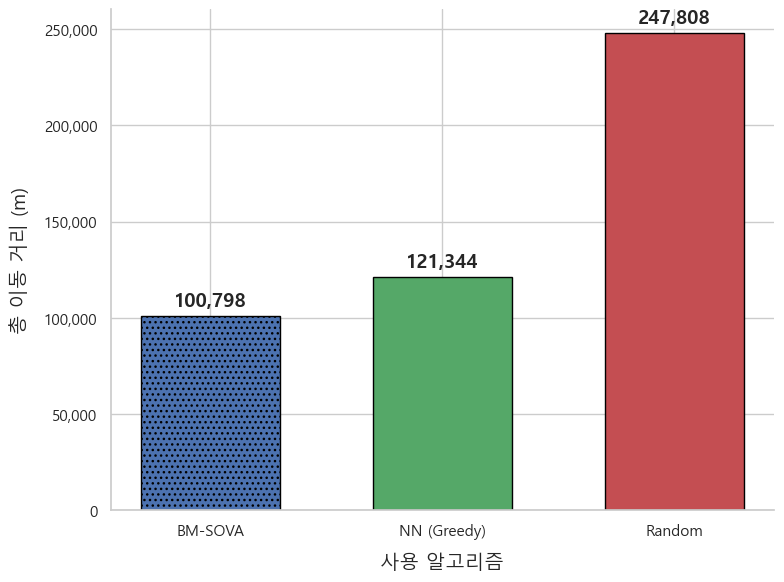

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

# 1. 데이터 설정
data = {
    'Method': ['BM-SOVA', 'NN (Greedy)', 'Random'],
    'Distance': [100798, 121344, 247808]
}
df = pd.DataFrame(data)

# 2. 스타일 및 폰트 설정 (순서 중요!)
# seaborn 테마를 먼저 적용한 후, 폰트를 설정해야 덮어씌워지지 않습니다.
sns.set_theme(style="whitegrid")
plt.rc('font', family='Malgun Gothic')  # 윈도우용 한글 폰트
plt.rc('axes', unicode_minus=False)     # 마이너스 기호 깨짐 방지

# 3. 그래프 그리기
plt.figure(figsize=(8, 6))
colors = ['#4c72b0', '#55a868', '#c44e52']
bars = plt.bar(df['Method'], df['Distance'], color=colors, edgecolor='black', width=0.6)

# SOVA는 점선 패턴 적용
bars[0].set_hatch('...')

# 4. Y축 천단위 쉼표 포맷 (경고 해결 부분)
# set_ticklabels 대신 Formatter를 사용하여 안전하게 변환
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# 5. 숫자 라벨 추가 (막대 위)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 3000,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# 6. 한글 제목 및 라벨 설정
plt.ylabel('총 이동 거리 (m)', fontsize=14, labelpad=10) # 한글 적용
plt.xlabel('사용 알고리즘', fontsize=14, labelpad=10)   # 한글 적용
#plt.title('총 이동 거리 비교', fontsize=14, fontweight='bold', pad=20) # 한글 적용

# 위쪽, 오른쪽 테두리 제거
sns.despine()

# 저장 및 출력
plt.tight_layout()
plt.savefig('travel_distance_chart_korean.png', dpi=300)
plt.show()

In [12]:
print(cluster_dist_sova)
print(cluster_dist_nn)
print(cluster_dist_random)
print(cluster_results)

[np.float64(1470.0313459956756), np.float64(2278.013585327944), np.float64(1708.7189719667272), np.float64(2162.2563234831164), np.float64(2719.332566557998), np.float64(2702.5379144249596), np.float64(3221.2407758859085), np.float64(4339.0), np.float64(4455.0), np.float64(4085.276752452652), np.float64(4734.0), np.float64(3751.0), np.float64(4791.0), np.float64(5963.0), np.float64(5852.657564508854), np.float64(3884.705733615869), np.float64(4194.0), np.float64(3797.3721330030803), np.float64(3406.0612718702437)]
[np.float64(1894.2030128375868), np.float64(2388.821987668858), np.float64(2779.5098826552244), np.float64(3216.14906847052), np.float64(3992.883976249026), np.float64(5882.174073401103), np.float64(3505.7314319191632), np.float64(4339.0), np.float64(5248.0), np.float64(5156.979032699336), np.float64(5709.0), np.float64(3970.0), np.float64(6184.0), np.float64(6223.0), np.float64(6860.381162074076), np.float64(4804.281104761091), np.float64(4459.0), np.float64(5693.12608180881

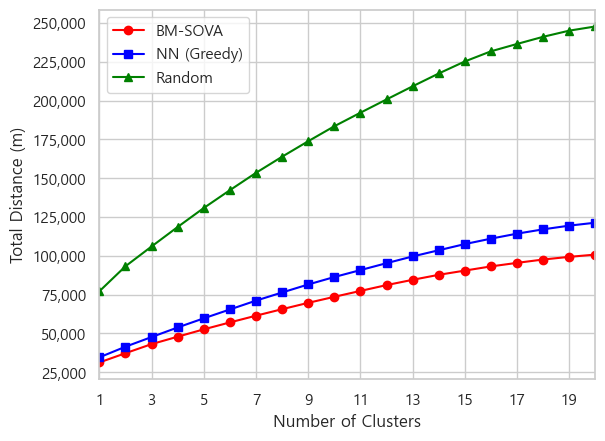

In [64]:
dist_nn = []
dist_sova = []
dist_random = []
dist_nn.append(data['Distance'][1]-sum(cluster_dist_nn))
dist_sova.append(data['Distance'][0]-sum(cluster_dist_sova))
dist_random.append(data['Distance'][2]-sum(cluster_dist_random))

cluster_dist_sova.sort(reverse=True)
for i in cluster_dist_sova:
    if len(dist_sova) == 0:
        dist_sova.append(i)
    else:
        dist_sova.append(dist_sova[-1] + i)

cluster_dist_random.sort(reverse=True)
for i in cluster_dist_random:
    if len(dist_random) == 0:
        dist_random.append(i)
    else:
        dist_random.append(dist_random[-1] + i)

cluster_dist_nn.sort(reverse=True)
for i in cluster_dist_nn:
    if len(dist_nn) == 0:
        dist_nn.append(i)
    else:
        dist_nn.append(dist_nn[-1] + i)

plt.plot(np.arange(start=1, stop=len(cluster_dist_sova)+2, dtype=int), dist_sova, label='BM-SOVA', color="red", marker='o')
plt.plot(np.arange(start=1, stop=len(cluster_dist_nn)+2, dtype=int), dist_nn, label='NN (Greedy)', color="blue", marker='s')
plt.plot(np.arange(start=1, stop=len(cluster_dist_random)+2, dtype=int), dist_random, label='Random', color="green", marker='^')
plt.xlabel('Number of Clusters')
plt.ylabel('Total Distance (m)')
plt.legend()
#plt.title('Total Distance by Cluster and Method')
plt.grid(True)


ax = plt.gca()
# x축 정수
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# y축 정수 + 콤마
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlim(1, len(cluster_dist_sova)+1)
ax.set_xticks(range(1, len(cluster_dist_sova)+2, 2))

In [26]:
print(dist_sova[0])

1470.0313459956756
